In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost
import re

In [2]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [3]:
def weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'
    

def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    df_mobility_index['weekday'] = df_mobility_index.date.dt.day_name()
    df_mobility_index = df_mobility_index[df_mobility_index.m50<200]
    df_mobility_index['weekend'] = df_mobility_index['weekday'].apply(lambda x: weekend(x))

    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

In [4]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
df_mobility.sample(5)

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend
122114,2020-09-12,Indiana,Bartholomew County,18005,2652,7.389,105,Saturday,Weekend
522640,2020-09-04,Wisconsin,Walworth County,55127,4077,9.218,98,Friday,Weekday
151935,2020-07-12,Iowa,Monona County,19133,524,13.078,67,Sunday,Weekend
234038,2020-08-15,Minnesota,Fillmore County,27045,676,8.286,55,Saturday,Weekend
338323,2020-04-28,North Dakota,Cass County,38017,3491,1.928,44,Tuesday,Weekday


In [5]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker

def get_spend_data():
    county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'

    df_county_spending = pd.read_csv(county_spending_url,low_memory=False)

    df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                                df_county_spending['month'].astype(str) + '-' + \
                                df_county_spending['day'].astype(str)
    df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
    df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
    df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
    print(df_county_spending.fips.nunique())
    df_county_spending.spend_all = df_county_spending.spend_all.str.replace('.','0.')
    df_county_spending.spend_all =df_county_spending.spend_all.astype(float)
    return df_county_spending

In [6]:
df_county_spending = get_spend_data()
df_county_spending

1672


,year,month,day,fips,spend_all,date
0,2020,1,6,01001,0.0000,2020-01-06
1,2020,1,6,01003,0.0000,2020-01-06
2,2020,1,6,01009,0.0000,2020-01-06
3,2020,1,6,01015,0.0000,2020-01-06
4,2020,1,6,01019,0.0000,2020-01-06
...,...,...,...,...,...,...
397931,2020,8,30,56035,-0.0148,2020-08-30
397932,2020,8,30,56037,0.0403,2020-08-30
397933,2020,8,30,56039,-0.1830,2020-08-30
397934,2020,8,30,56041,-0.1740,2020-08-30


In [7]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [270]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid_merged = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid_rate = get_covid_rates()
df_covid = pd.merge(left = df_covid_merged, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_covid = df_covid.dropna(subset=['Lat'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths,case_rate,new_case_rate,death_rate,new_death_rate
0,01001,32.539527,-86.644082,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
750933,56037,41.659439,-108.882788,2020-09-16,317.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN
750934,56039,43.935225,-110.589080,2020-09-16,481.0,3.0,1.0,0.0,NaN,NaN,NaN,NaN
750935,56041,41.287818,-110.547578,2020-09-16,323.0,11.0,2.0,0.0,NaN,NaN,NaN,NaN
750936,56043,43.904516,-107.680187,2020-09-16,111.0,0.0,6.0,0.0,NaN,NaN,NaN,NaN


In [9]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [10]:
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [11]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby(['FIPS'])['candidatevotes'].transform(max) == county_election['candidatevotes']]
fips = county_election['FIPS'][county_election.groupby(['FIPS'])['candidatevotes'].transform(max) == county_election['candidatevotes']]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

,FIPS,party,pct_republican
0,01001,republican,0.753775
1,01003,republican,0.797922
2,01005,republican,0.528232
3,01007,republican,0.782397
4,01009,republican,0.913812
...,...,...,...
3149,02037,democrat,0.444597
3150,02038,democrat,0.293002
3151,02039,democrat,0.308995
3152,02040,democrat,0.370659


In [12]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo = df_county_demo.fillna(df_county_demo.mean())
df_county_demo.isna().sum()

YEAR                                                                                   0
STATE                                                                                  0
COUNTY                                                                                 0
NAME_E                                                                                 0
Sex by Age_Total                                                                       0
                                                                                    ... 
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed      0
fips                                                                                   0
AKGVE001                                                                               0
party                                                                                106
pct_republican                                                                         0
Length: 150, dtype: i

In [14]:
county_dict = df_county_demo.set_index('fips')['COUNTY'].to_dict()
state_dict = df_county_demo.set_index('fips')['STATE'].to_dict()
def get_name(name_dict, x):
    
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['STATE'] = df_mobility_rm['fips'].apply(lambda x: get_name(state_dict, x))
df_mobility_rm['COUNTY'] = df_mobility_rm['fips'].apply(lambda x: get_name(county_dict, x))

# Mobility Reduction

In [20]:
df_mob_rm_train = df_mobility_rm.copy()

In [269]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob'] #,'spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_post_covid= df_mob_rm_train[df_mob_rm_train.date>=covid_date]
df_pre = df_mob_rm_train[(df_mob_rm_train.date<covid_date)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = df_covid_mean.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob
1094,26015,12.305929,0.345571,2020-04-15,31,0.031352,0.971918
982,22023,18.239622,10.037857,2020-03-30,15,0.029978,0.449667
1357,29097,7.337367,3.638857,2020-04-14,30,0.016802,0.504065
336,13001,12.226980,3.903286,2020-04-09,25,0.027231,0.680765
2650,56003,3.711439,0.739143,2020-04-16,32,0.025026,0.800847


In [96]:
def plot_metric(df, col,name):
    plt.figure(figsize=(10,8))
    plt.rcParams["patch.force_edgecolor"] = True

    df[col].hist(bins = 50)
    plt.xlabel(name, fontsize=16)
    plt.ylabel('Count', fontsize = 16)

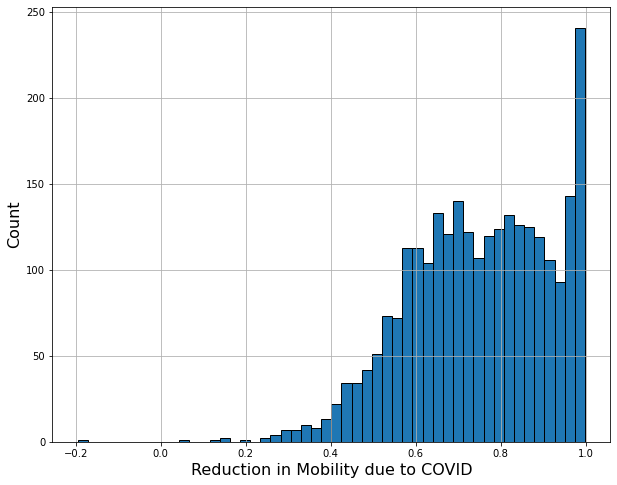

In [97]:
plot_metric(df_mob_spend_red,'Pct_Red_rolling_mean_mob','Reduction in Mobility due to COVID')

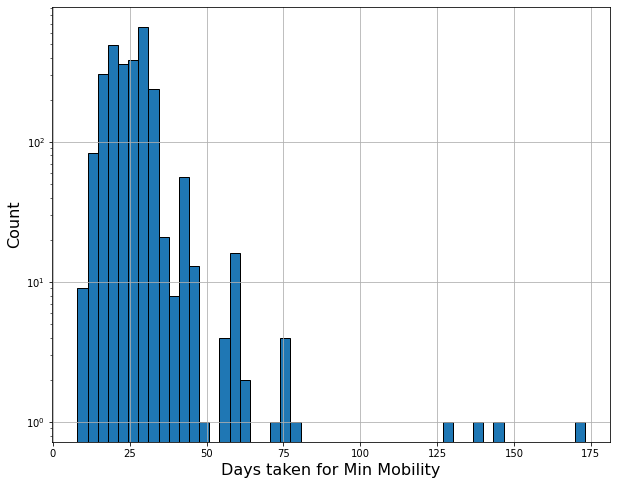

In [98]:
plot_metric(df_mob_spend_red,'Drop_days_rolling_mean_mob','Days taken for Min Mobility')
plt.yscale('log')

In [46]:
# df_merged = pd.merge(left = df_mobility, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
# df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
# df_merged.corr()

In [290]:
df_covid_case_mean = pd.DataFrame(columns=['fips','mean_case_rate' ])
df_covid_death_mean = pd.DataFrame(columns=['fips','mean_death_rate' ])

for fips in df_mob_spend_red.fips.unique():
    date_thr = df_mob_spend_red[df_mob_spend_red.fips==fips]['min_date_rolling_mean_mob'].values[0]
    mean_case_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_cases'].mean()
    mean_death_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_deaths'].mean()
    df_covid_case_mean = df_covid_case_mean.append({'fips':fips,'mean_case_rate':mean_case_rate},ignore_index=True)
    df_covid_death_mean = df_covid_death_mean.append({'fips':fips,'mean_death_rate':mean_death_rate},ignore_index=True)

df_covid_death_mean

,fips,mean_death_rate
0,01001,0.024390
1,01003,0.023256
2,01005,0.000000
3,01007,0.000000
4,01009,0.000000
...,...,...
2662,56033,0.000000
2663,56035,0.000000
2664,56037,0.000000
2665,56039,0.000000


In [493]:
def load_Atlas(fpath = './Data/Atlas County Info/RuralAtlasData22.xlsx'):
    xls_atlas = pd.ExcelFile(fpath)
    df_atlas = pd.DataFrame()
    for sheet in xls_atlas.sheet_names:
        if sheet != 'Read Me' and sheet != 'Variable Name Lookup' :
            df_atlas_sheet = pd.read_excel(xls_atlas, sheet_name=sheet)
            df_atlas_sheet = df_atlas_sheet.drop(columns = ['State','County'] )
            
            if 'FIPStxt' not in df_atlas_sheet.columns:
                df_atlas_sheet = df_atlas_sheet.iloc[1:]
            else:
                df_atlas_sheet = df_atlas_sheet.rename(columns ={'FIPStxt':'FIPS'})

            if len(df_atlas)!=0:
                df_atlas = df_atlas.join(df_atlas_sheet.set_index('FIPS'), on ='FIPS')
            else:
                df_atlas = df_atlas_sheet.copy()
    df_atlas.FIPS = df_atlas.FIPS.astype(int).astype(str).str.zfill(5)
    df_atlas = df_atlas.fillna(df_atlas.mean())
    return df_atlas
                

In [494]:
def load_CUSP( sheet_name,excel_fname='./Data/COVID-19 US state policy database (CUSP).xlsx',remove_cols=[]):
    xls = pd.ExcelFile(excel_fname)
    df = pd.read_excel(xls, sheet_name)
    df=df.dropna()
    df = df.drop(columns = ['State Abbreviation','State FIPS Code'] + remove_cols)
    start_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
    for col in df.columns:
        
        if col!= 'State':
            if df[col].isin([0,1]).all() or df[col].isin([0,1,2]).all():
                df[col]= df[col].fillna(df[col].min())
                continue
            else:
                df[col] = pd.to_datetime(df[col],format='%Y-%m-%d',errors='coerce')
                df[col] = df[col].fillna(df[col].max())
                df['Days_' +col] = (df[col]- start_date).dt.days
                df = df.drop(columns=[col])
    df = df.rename(columns={'State':'STATE'})
    return df

In [496]:
sheet_list = ['State of Emergency','Physical Distance Closures','Stay at Home',
              'Unemployment Insurance','Housing','Quarantine Rules','Food Security']

In [499]:
def get_model_df(df_mob_spend_red,df_covid_case_mean,df_covid_death_mean,df_county_demo,sheet_list):
    df_model = df_mob_spend_red.join(df_covid_case_mean.set_index('fips'), on='fips')
    df_model = df_model.join(df_covid_death_mean.set_index('fips'), on='fips')

    df_model = df_model.join(df_county_demo.set_index('fips'), on ='fips')
    df_CUSP = pd.DataFrame()
    for sheet in sheet_list:
        df_CUSP_sheet = load_CUSP(sheet)
        if len(df_CUSP)!=0:
            df_CUSP = df_CUSP.join(df_CUSP_sheet.set_index('STATE'), on='STATE')
        else:
            df_CUSP = df_CUSP_sheet.copy()
            
    df_model = df_model.join(df_CUSP.set_index('STATE'), on='STATE')
    df_atlas = load_Atlas()
    df_model = df_model.join(df_atlas.set_index('FIPS'),on='fips')

    return df_model



In [500]:
df_model = get_model_df(df_mob_spend_red,df_covid_case_mean,df_covid_death_mean,df_county_demo,sheet_list)
df_model

,fips,rolling_mean_mob,Min_rolling_mean_mob,min_date_rolling_mean_mob,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,mean_case_rate,mean_death_rate,YEAR,...,PctVetsDisabilty,PctNonVetsDisabilty,CivPopVets18to64Num,CivPop18ONum,Vets18ONum,NonVetsDisabilty,NonVetsPoor,VetsDisabilty,VetsPoor,CLFVets18to64Num
0,01001,12.671049,4.551286,2020-04-10,26,0.024647,0.640812,0.414634,0.024390,2014-2018,...,18.956229,15.927258,2533.0,41284.0,5071.0,4782.0,4562.0,563.0,142.0,2995.0
1,01003,11.064776,4.432000,2020-04-12,28,0.021409,0.599450,1.651163,0.023256,2014-2018,...,17.109763,10.749077,7058.0,162122.0,19354.0,11873.0,11795.0,1551.0,635.0,9172.0
2,01005,9.453480,4.576286,2020-04-17,33,0.015634,0.515915,0.312500,0.000000,2014-2018,...,38.164251,17.903577,359.0,20346.0,1561.0,2217.0,3225.0,237.0,79.0,732.0
3,01007,20.897776,8.262571,2020-04-12,28,0.021594,0.604620,0.372093,0.000000,2014-2018,...,28.839590,14.029267,345.0,17868.0,1278.0,1649.0,1595.0,169.0,50.0,635.0
4,01009,20.327806,9.241143,2020-04-12,28,0.019478,0.545394,0.302326,0.000000,2014-2018,...,26.007109,11.575693,1041.0,44126.0,3765.0,3707.0,4218.0,439.0,121.0,1688.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,56033,3.167724,1.506571,2020-04-15,31,0.016916,0.524399,0.260870,0.000000,2014-2018,...,12.800000,9.907278,947.0,23437.0,2681.0,1560.0,1014.0,160.0,62.0,1276.0
2663,56035,4.023847,0.464857,2020-04-06,22,0.040203,0.884474,0.027027,0.000000,2014-2018,...,0.000000,11.848426,216.0,7523.0,711.0,666.0,487.0,0.0,0.0,216.0
2664,56037,4.954561,2.241571,2020-04-16,32,0.017112,0.547574,0.212766,0.000000,2014-2018,...,12.079511,11.914236,1178.0,32302.0,2667.0,3084.0,2939.0,158.0,109.0,1320.0
2665,56039,6.590816,0.656000,2020-04-06,22,0.040930,0.900468,1.081081,0.000000,2014-2018,...,27.105263,6.783036,296.0,18625.0,984.0,1022.0,1276.0,103.0,13.0,380.0


In [501]:
df_model.corr()['Pct_Red_rolling_mean_mob'][abs(df_model.corr()['Pct_Red_rolling_mean_mob'])>0.4]

Min_rolling_mean_mob                                                                                                                                        -0.800111
Norm_Drop_Rate_rolling_mean_mob                                                                                                                              0.641053
Pct_Red_rolling_mean_mob                                                                                                                                     1.000000
Per Capita Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)    0.431079
pct_republican                                                                                                                                              -0.406738
Days_Closed non-essential businesses                                                                                                                        -0.429542
Days

In [502]:
def run_model(df,df_source,name,task_type='GPU',max_depth= 6):
    
    target_var = ['Pct_Red_rolling_mean_mob']
    keep_cols = ['Pct_Red_rolling_mean_mob', 'rolling_mean_mob']
    remove_cols = ['fips', 'YEAR','COUNTY','NAME_E' ] + [col for col in df_source.columns if col not in keep_cols]
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("party")]
    
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.15,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 0.1555539	total: 79.9ms	remaining: 1m 19s
200:	learn: 0.0208765	total: 14.2s	remaining: 56.5s
400:	learn: 0.0053516	total: 28.3s	remaining: 42.3s
600:	learn: 0.0019280	total: 43.2s	remaining: 28.7s
800:	learn: 0.0008626	total: 57.9s	remaining: 14.4s
999:	learn: 0.0004296	total: 1m 12s	remaining: 0us
0.56


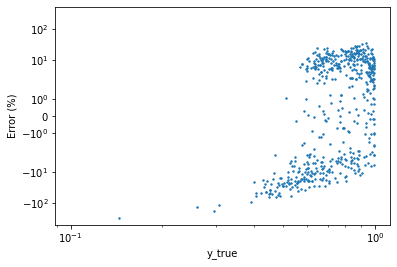

,Pre_Covid_Feature_Importance
Days_Stay at home/ shelter in place,9.748948
pct_republican,3.738061
STATE,3.567291
ForeignBornEuropePct,2.140542
rolling_mean_mob,2.014000
Days_Closed movie theaters,1.871127
Days_Stop enforcement of evictions overall or due to COVID related issues,1.795229
"Means of Transportation to Work_Car, truck, or van Drove alone",1.724682
ForeignBornEuropeNum,1.627954
"Means of Transportation to Work_Car, truck, or van",1.542293


In [503]:
df_model_fi,y_test,y_pred_cb = run_model(df_model,df_mob_spend_red,name = 'Pre', task_type='CPU',max_depth = 7)
df_model_fi.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 527 ||| Records with over 200% error 3


,error_pct,Count
STATE,,
West Virginia,-156.689254,11
South Dakota,-24.614572,3
Colorado,-21.578625,14
Louisiana,-17.496962,10
Georgia,-15.525721,32
Arkansas,-14.454775,10
Mississippi,-10.786970,14
Nebraska,-10.048809,11
Virginia,-8.209153,23


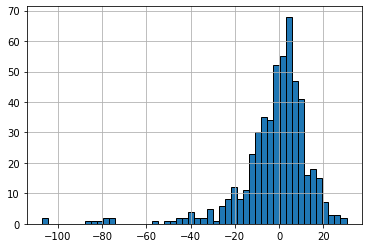

In [492]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test.Pct_Red_rolling_mean_mob - y_test.pred)*100/y_test.Pct_Red_rolling_mean_mob
test_data = df_model.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=50)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].mean(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')

In [489]:
df_model.groupby('STATE')['Pct_Red_rolling_mean_mob'].std().sort_values()

STATE
Hawaii            0.010701
Massachusetts     0.015262
Maine             0.029487
Vermont           0.029748
New York          0.034441
Michigan          0.037302
New Jersey        0.039880
Alaska            0.041028
Connecticut       0.042517
Rhode Island      0.042552
New Hampshire     0.048391
Pennsylvania      0.053641
Wisconsin         0.071490
Minnesota         0.072065
Delaware          0.078774
Maryland          0.079882
Washington        0.084885
Indiana           0.092738
Ohio              0.094431
Alabama           0.102144
South Carolina    0.108357
Louisiana         0.114819
Mississippi       0.115807
Oklahoma          0.116631
Iowa              0.119291
Kentucky          0.119789
Tennessee         0.121645
Arkansas          0.122358
Illinois          0.125073
California        0.130196
Oregon            0.130565
Idaho             0.130635
North Carolina    0.131746
Missouri          0.135283
Georgia           0.143531
Arizona           0.143969
Texas             0.14